In [25]:
pip install torch torchvision matplotlib jupyter



[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [26]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset,DataLoader
import matplotlib.pyplot as plt

In [27]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using:", device)

Using: mps


In [28]:
class MNISTCSV(Dataset):
    def __init__(self, csv_file):
        df = pd.read_csv(csv_file)
        self.labels = torch.tensor(df.iloc[:, 0].values, dtype=torch.long)
        self.images = torch.tensor(df.iloc[:, 1:].values / 255.0, dtype=torch.float32) 

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

train_dataset = MNISTCSV("mnist_train.csv")
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

In [29]:
class BetaVAE(nn.Module):
    def __init__(self, latent_dim=10):
        super(BetaVAE, self).__init__()
        self.fc1 = nn.Linear(28*28, 400)
        self.fc21 = nn.Linear(400, latent_dim)  
        self.fc22 = nn.Linear(400, latent_dim)  
        self.fc3 = nn.Linear(latent_dim, 400)
        self.fc4 = nn.Linear(400, 28*28)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 28*28))
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar

In [30]:
def loss_function(recon_x, x, mu, logvar, beta=4.0):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 28*28), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + beta * KLD

In [31]:
model = BetaVAE(latent_dim=10).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [32]:
epochs = 5
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for imgs, _ in train_loader:
        imgs = imgs.to(device)
        optimizer.zero_grad()
        recon, mu, logvar = model(imgs)
        loss = loss_function(recon, imgs, mu, logvar, beta=4.0)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader.dataset):.4f}")


Epoch 1, Loss: 188.8998
Epoch 2, Loss: 160.6926
Epoch 3, Loss: 156.4485
Epoch 4, Loss: 154.4579
Epoch 5, Loss: 153.4511


In [33]:
def visualize_recon(model, data_loader):
    model.eval()
    with torch.no_grad():
        for imgs, _ in data_loader:
            imgs = imgs.to(device)
            recon, _, _ = model(imgs)
            break

    imgs = imgs.cpu().numpy().reshape(-1, 28, 28)
    recon = recon.cpu().numpy().reshape(-1, 28, 28)

    fig, axes = plt.subplots(2, 6, figsize=(12, 4))
    for i in range(6):
        axes[0, i].imshow(imgs[i], cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].imshow(recon[i], cmap='gray')
        axes[1, i].axis('off')
    plt.suptitle("Top: Original | Bottom: Reconstructed")
    plt.show()



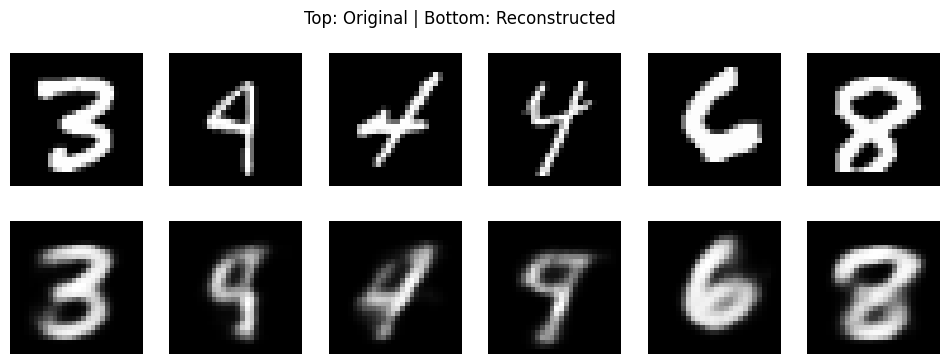

In [34]:
visualize_recon(model, train_loader)

In [37]:
model.eval()
imgs, _ = next(iter(train_loader))  
img = imgs[0].to(device).unsqueeze(0)  
with torch.no_grad():
    mu, logvar = model.encode(img.view(-1, 28*28))


In [38]:
latent_dim = mu.shape[1]
traversals = torch.linspace(-3, 3, steps=9).to(device) 
images = []

for i in range(latent_dim):
    z = mu.repeat(9, 1) 
    z[:, i] = traversals 
    with torch.no_grad():
        recon = model.decode(z).cpu().view(-1, 28, 28)
        images.append(recon)

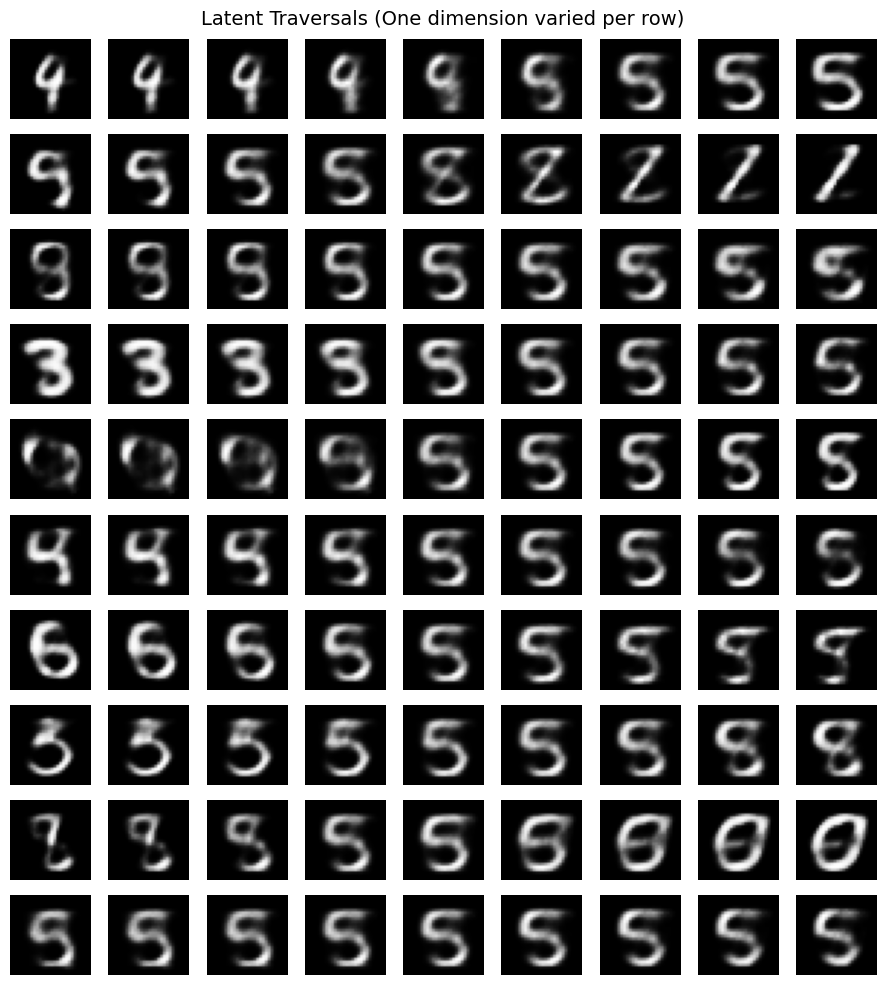

In [39]:
fig, axes = plt.subplots(latent_dim, 9, figsize=(9, latent_dim))
for i in range(latent_dim):
    for j in range(9):
        axes[i, j].imshow(images[i][j], cmap='gray')
        axes[i, j].axis('off')
plt.suptitle("Latent Traversals (One dimension varied per row)", fontsize=14)
plt.tight_layout()
plt.show()